In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

C:\Users\Ken\Anaconda3\envs\qt\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img_h = img_w = 64              # We will resized images  64x64
img_size_flat = img_h * img_w    # 64x64=4096, the total number of pixels
n_classes = 1                    # Number of classes, one class per digit
n_channels = 3

In [3]:
data = np.load('cat_dog_dataset.npy')
X_train = data.item().get('X_train')
y_train = data.item().get('y_train')
X_test = data.item().get('X_test')
y_test = data.item().get('y_test')
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (4000, 64, 64, 3)
y_train (4000, 1)
X_test (1000, 64, 64, 3)
y_test (1000, 1)


In [4]:
def randomize(x, y):
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y
def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [5]:
logs_path = "./logs"  
lr = 0.001  
epochs = 50
batch_size = 100  
display_freq = 10

In [6]:
def conv2d(x, filter_shape, name):
    W = tf.Variable(tf.random_normal(filter_shape))
    b = tf.Variable(tf.random_normal([filter_shape[-1]]))
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
#    return tf.nn.relu(x)
    return x
def max_pool(x, ksize, stride, name):
    return tf.nn.max_pool(x, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding="SAME",name=name)

def flatten_layer(layer):
    with tf.variable_scope('Flatten_layer'):
        num_features = layer.shape[1:].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [7]:
with tf.name_scope('Input'):
    X = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels], name='X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
    
conv1 = conv1 = conv2d(X, [3, 3, 3, 32], name="conv1")
pool1 = max_pool(conv1, ksize=2, stride=2, name='pool1')
conv2 = conv2d(pool1, [3, 3, 32, 64], name='conv2') 
pool2 = max_pool(conv2, ksize=2, stride=2, name='pool2')
layer_flat = flatten_layer(pool2)
fc1 = tf.layers.dense(layer_flat, units=128, activation=tf.nn.relu)
output_logits = tf.layers.dense(fc1, n_classes)

In [8]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam-op').minimize(loss)
    
    with tf.variable_scope('Accuracy'):
        pred = tf.nn.sigmoid(output_logits)
        correct_prediction = tf.equal(tf.round(pred), y, name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    
    with tf.variable_scope('Prediction'):
        pred = tf.nn.sigmoid(output_logits)
        cls_prediction = tf.round(pred, name='predictions')

<font color=black size=3>5.4. Initialize all variables and merge the summaries

In [9]:
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

<font color=black size=5>6. Train

In [10]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
num_tr_iter = int(len(y_train) / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    X_train, y_train = randomize(X_train, y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        X_batch, y_batch = get_next_batch(X_train, y_train, start, end)

        # Run optimization op (backprop)
        feed_dict_batch = {X: X_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)

            print("iter {0:3d}:\t Loss={1:.5f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_test = {X: X_test, y: y_test}
    loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
    print('---------------------------------------------------------')
    print("Epoch: {0}, test loss: {1:.5f}, test accuracy: {2:.01%}".
          format(epoch + 1, loss_test, acc_test))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=1126.16565,	Training Accuracy=55.0%
iter  10:	 Loss=18.14694,	Training Accuracy=48.0%
iter  20:	 Loss=2.32702,	Training Accuracy=64.0%
iter  30:	 Loss=4.14352,	Training Accuracy=53.0%
---------------------------------------------------------
Epoch: 1, test loss: 8.17913, test accuracy: 49.4%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=8.58409,	Training Accuracy=53.0%
iter  10:	 Loss=3.84855,	Training Accuracy=67.0%
iter  20:	 Loss=1.66643,	Training Accuracy=65.0%
iter  30:	 Loss=1.38022,	Training Accuracy=70.0%
---------------------------------------------------------
Epoch: 2, test loss: 1.51692, test accuracy: 64.8%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=1.21541,	Training Accuracy=72.0%
iter  10:	 Loss=1.48549,	Training Accuracy=72.0%
iter  20:	 Loss=3.65463,	Training Accuracy=63.0%
iter  30:	 Loss=3.89859,	Training Accuracy=59.0%
--------------------

iter  30:	 Loss=0.50242,	Training Accuracy=81.0%
---------------------------------------------------------
Epoch: 22, test loss: 1.67666, test accuracy: 70.5%
---------------------------------------------------------
Training epoch: 23
iter   0:	 Loss=0.33534,	Training Accuracy=87.0%
iter  10:	 Loss=0.17040,	Training Accuracy=90.0%
iter  20:	 Loss=0.21189,	Training Accuracy=90.0%
iter  30:	 Loss=0.35044,	Training Accuracy=88.0%
---------------------------------------------------------
Epoch: 23, test loss: 1.59107, test accuracy: 69.6%
---------------------------------------------------------
Training epoch: 24
iter   0:	 Loss=0.09338,	Training Accuracy=96.0%
iter  10:	 Loss=0.09155,	Training Accuracy=97.0%
iter  20:	 Loss=0.41614,	Training Accuracy=89.0%
iter  30:	 Loss=0.26591,	Training Accuracy=92.0%
---------------------------------------------------------
Epoch: 24, test loss: 2.40943, test accuracy: 63.1%
---------------------------------------------------------
Training epoch: 2

iter   0:	 Loss=0.04284,	Training Accuracy=99.0%
iter  10:	 Loss=0.01359,	Training Accuracy=100.0%
iter  20:	 Loss=0.97416,	Training Accuracy=79.0%
iter  30:	 Loss=0.26745,	Training Accuracy=91.0%
---------------------------------------------------------
Epoch: 44, test loss: 1.77755, test accuracy: 69.3%
---------------------------------------------------------
Training epoch: 45
iter   0:	 Loss=0.06156,	Training Accuracy=99.0%
iter  10:	 Loss=0.02154,	Training Accuracy=100.0%
iter  20:	 Loss=0.07553,	Training Accuracy=96.0%
iter  30:	 Loss=0.03463,	Training Accuracy=100.0%
---------------------------------------------------------
Epoch: 45, test loss: 1.67025, test accuracy: 69.2%
---------------------------------------------------------
Training epoch: 46
iter   0:	 Loss=0.01152,	Training Accuracy=100.0%
iter  10:	 Loss=0.01632,	Training Accuracy=100.0%
iter  20:	 Loss=0.01349,	Training Accuracy=100.0%
iter  30:	 Loss=0.03267,	Training Accuracy=99.0%
--------------------------------

<font color=black size=5>7. Test

Accuracy of random 10 images: 0.78


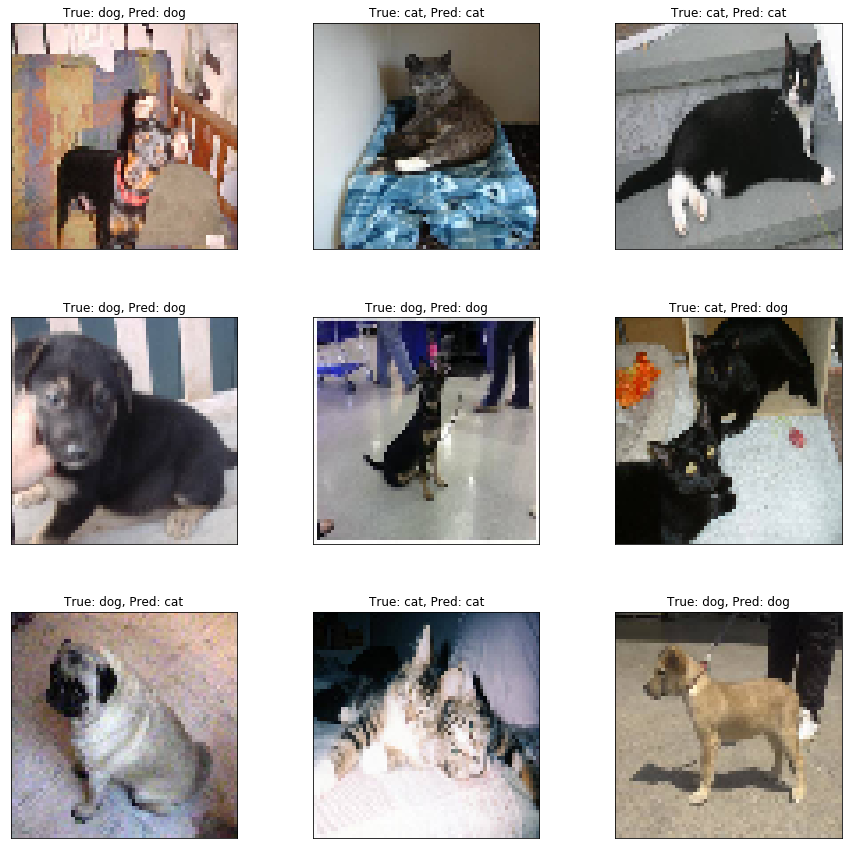

In [13]:
test_list = {
    'X': [],
    'y': []
}
import random
for x in range(9):
    rand_idx = random.randint(0, 999)
    test_list['X'].append(X_test[rand_idx])
    test_list['y'].append(y_test[rand_idx])
test_list['X'] = np.array(test_list['X'])
test_list['y'] = np.array(test_list['y'])

y_pred, acc = sess.run([pred, accuracy], feed_dict={X: test_list['X'], y: test_list['y']})
print('Accuracy of random 10 images: %.2f' % acc)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
    ax.imshow(test_list['X'][i])
    mapping = ['cat', 'dog']
    cls_true = int(test_list['y'][i])
    cls_pred = int(np.round(y_pred[i]))
    ax.set_title("True: {0}, Pred: {1}".format(mapping[cls_true], mapping[cls_pred]))
    ax.set_xticks([])
    ax.set_yticks([])